### [Udacity solution LunarLander DQN](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution)
### [Pytorch tutorial DQN CartPole](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
### [RL-Adventure](https://github.com/higgsfield/RL-Adventure)
### [17 algos pytorch](https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch)

In [15]:
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import math
import random
import fastprogress
from tqdm import tqdm_notebook as tqdm
from collections import deque, namedtuple

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

print("Pytorch:     ", torch.__version__, "( GPU:", torch.cuda.is_available(),")")
print("OpenAi Gym:  ", gym.__version__)
print("Fastprogress:", fastprogress.__version__)

Pytorch:      1.3.1 ( GPU: False )
OpenAi Gym:   0.15.4
Fastprogress: 0.1.22


In [2]:
######################### Classic control
doblePendulo    = "Acrobot-v1"
paloBalanceado  = "CartPole-v1"
cocheColina     = "MountainCar-v0"
cocheColinaCont = "MountainCarContinuous-v0"
pendulo         = "Pendulum-v0"

######################### Box2D
BipedalWalker         = "BipedalWalker-v2"
BipedalWalkerHardcore = "BipedalWalkerHardcore-v2"
CarRacing             = "CarRacing-v0"
LunarLander           = "LunarLander-v2"
LunarLanderContinuous = "LunarLanderContinuous-v2"

In [3]:
env = gym.make(LunarLander)
print("INPUT  (Observation): ", env.observation_space)
print("OUTPUT (Agent action):", env.action_space)

INPUT  (Observation):  Box(8,)
OUTPUT (Agent action): Discrete(4)


In [4]:
print("\tmin:",env.observation_space.low)
print("\tmax:",env.observation_space.high)

	min: [-inf -inf -inf -inf -inf -inf -inf -inf]
	max: [inf inf inf inf inf inf inf inf]


In [6]:
state = env.reset()

for _ in range(400):
    env.render()
    action = env.action_space.sample() # your agent here (this takes random actions)
    state, reward, done, info = env.step(action)
    
    if done:
        state = env.reset()
env.close()

# LunarLander-v2 (Discrete)

### [Paper solution](https://www.researchgate.net/publication/333145451_Deep_Q-Learning_on_Lunar_Lander_Game)

### INPUT (8)

- Agent’s position $(x, y)$ in space
- Horizontal and vertical velocity ($v_x, v_y$)
- Orientation in space $\theta$
- Angular velocity $v_\theta$
- 2 bool flags indicating whether the left/right foot  is in contact with the ground.

### OUTPUT (4) (Discrete)
- `0`: Do nothing
- `1`: Fire left engine
- `2`: Fire down engine
- `3`: Fire right engine

### REWARD
- discounted
- cumulative
- From -300 to 300

![](https://miro.medium.com/max/740/1*i7lxpgt2K3Q8lgEPJu3_xA.png)

# Utils

In [5]:
def copyNet(source, target, way="hard", copy_perc=0.001): ## COPY_PERC a.k.a TAU
    
    if way=="hard":
        target.load_state_dict(source.state_dict())
    
    if way=="soft":
        # τ*θ_local + (1 - τ)*θ_target
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(COPY_PERC*source_param.data + (1.0-COPY_PERC)*target_param.data)
    
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

# Epsilon greedy exploration

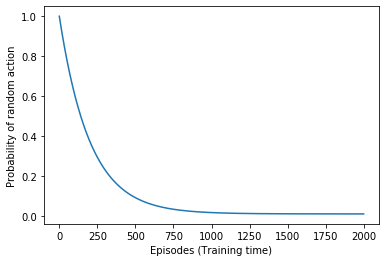

In [29]:
EPISODES  = 2000
EPS_START = 1
EPS_END   = 0.01
EPS_DECAY = 200

def prob_actionRandom(timestamp):
    return EPS_END + (EPS_START - EPS_END) * math.exp(-1. * timestamp / EPS_DECAY)

plt.ylabel('Probability of random action')
plt.xlabel('Episodes (Training time)')
plt.plot([prob_actionRandom(i) for i in range(EPISODES)]);

# Agent (Neural Net)

In [10]:
class Agent(nn.Module):

    def __init__(self, state_size, action_size, seed=0, fc1_units=64, fc2_units=64):
        super(Agent, self).__init__()
        self.action_size = action_size
        self.seed = torch.manual_seed(seed)
        self.fc1  = nn.Linear(state_size, fc1_units)
        self.fc2  = nn.Linear(fc1_units, fc2_units)
        self.fc3  = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
    def chooseAction(self, stateNumpy, epsilon):

        if random.random() > epsilon:
            # INFERENCE MODEL
            stateTensor   = torch.from_numpy(stateNumpy)
            actionsTensor = self.forward(stateTensor)
            return outputTensor.argmax().item()
        else:
            # RANDOM ACTION
            return random.randrange(self.action_size)


policy_net = Agent(state_size=8, action_size=4).to(DEVICE) # Actor for compute rewards
target_net = Agent(state_size=8, action_size=4).to(DEVICE) # Learn from actor episodes
copyNet(source=policy_net, target=target_net)
target_net.eval()

############################ TEST AGENT
inputNumpy   = env.reset()
inputTensor  = torch.from_numpy(inputNumpy)#.unsqueeze(0).to(DEVICE)
outputTensor = policy_net(inputTensor)

print("INPUT (state):   ", inputTensor)
print("OUTPUT (actions):", outputTensor)
print("Selected output: ", outputTensor.argmax().item())

INPUT (state):    tensor([-0.0028,  1.4065, -0.2841, -0.1958,  0.0033,  0.0644,  0.0000,  0.0000])
OUTPUT (actions): tensor([ 0.1029, -0.0220, -0.0750, -0.0274], grad_fn=<AddBackward0>)
Selected output:  0


# Memory
Stores the transitions that the agent observes, allowing us to reuse this data later.

In [11]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward", "done"))

class PlayMemory(object):

    def __init__(self, max_size):
        self.transitions = deque(maxlen=max_size)  

    def push(self, *args):
        self.transitions.append(Transition(*args))

    def sample(self, batch_size):
        sampleTransitions = random.sample(self.transitions, batch_size)
        states      = torch.from_numpy(np.vstack([t.state      for t in sampleTransitions if t is not None])).float().to(DEVICE)
        actions     = torch.from_numpy(np.vstack([t.action     for t in sampleTransitions if t is not None])).long().to(DEVICE)
        rewards     = torch.from_numpy(np.vstack([t.reward     for t in sampleTransitions if t is not None])).float().to(DEVICE)
        next_states = torch.from_numpy(np.vstack([t.next_state for t in sampleTransitions if t is not None])).float().to(DEVICE)
        dones       = torch.from_numpy(np.vstack([t.done       for t in sampleTransitions if t is not None]).astype(np.uint8)).float().to(DEVICE)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.transitions)

# Computing Temporal Difference Loss

In [17]:
def compute_td_loss(optimizer, batch_size, gamma):
    
    # 1) GET BATCH FROM PLAYED MEMORY 
    states, actions, rewards, next_states, dones = memory.sample(batch_size)
    
    # 2) Compute Q values
    q_value          = policy_net(states).gather(1, actions)
    next_q_value     = target_net(next_states).max(1)[0].unsqueeze(1)
    expected_q_value = rewards + gamma * next_q_value * (1 - done)
    
    # 3) COMPUTE LOSS
    loss = F.mse_loss(q_value, expected_q_value)
        
    # 4) OPTIMIZE
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [27]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    
    plt.subplot(121)
    plt.title('Iteration %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.xlabel('Episodes')
    plt.plot(rewards)
    
    plt.subplot(122)
    plt.title('Loss')
    plt.xlabel('Episodes')
    plt.plot(losses, color="green")
    
    plt.show()

# Main loop (deep Q-Learning)

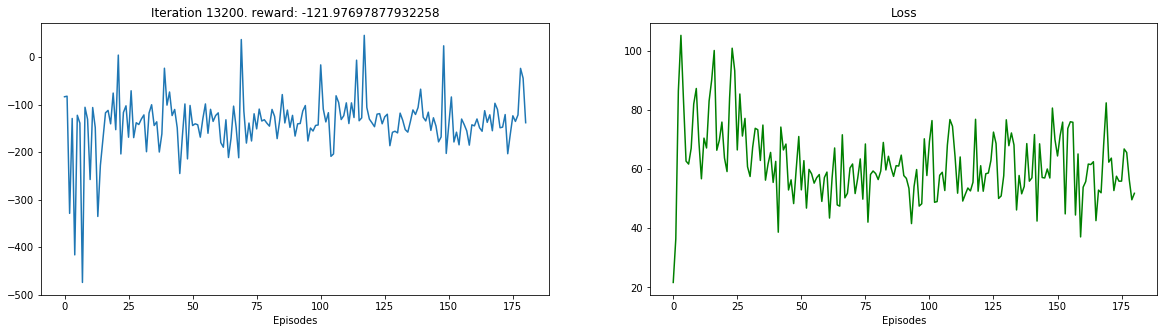

KeyboardInterrupt: 

In [28]:
NUM_STEPS   = 100000
EPISODES    = 500   # Number of training gameplays (2000)
MAX_ITERS   = 1000  # Max number of iterations per episode

BATCH_SIZE  = 64    # Minibatch size
GAMMA       = 0.99  # Discount factor
LR          = 5e-4  # Learning rate

COPY_PERC   = 1e-3
TARGET_UPDATE = 4   # How often to update the target network (num episodes)


memory      = PlayMemory(max_size=100000)

#optimizer  = optim.RMSprop(policy_net.parameters())
OPTIMIZER   = optim.Adam(policy_net.parameters(), lr=LR)

rewards      = []
last_rewards = deque(maxlen=100)
episodes     = []

all_rewards = []
episode_reward = 0




num_steps  = 100000
batch_size = 32
gamma      = 0.99

losses     = []
rewards    = []

episode_reward = 0
episode_losses = []

state   = env.reset()
epsilon = 1
#mb       = fastprogress.master_bar(range(NUM_STEPS))
#mb.names = ['Step']
for i in range(NUM_STEPS):
    
    action  = policy_net.chooseAction(state, epsilon)    # Select action from the agent
    next_state, reward, done, _ = env.step(action)       # Perform action in the enviroment
    memory.push(state, action, next_state, reward, done) # Store the transition in memory
    state = next_state                                   # Define next state
    episode_reward += reward                             # Store reward

    if done:                              # If episode is finish...
        state   = env.reset()             # Reset the enviroment
        epsilon = prob_actionRandom(i)    # Decrease the perecentage of random action 
        copyNet(source=policy_net, target=target_net, way="soft", copy_perc=COPY_PERC)
        
        rewards.append(episode_reward)
        episode_reward = 0
        losses.append(sum(episode_losses) / len(episode_losses) )
        episode_losses = []
        
        
    # If the playMemory has enough data, then optimize
    # Perform one step of the optimization (on the target network)
    if len(memory) > BATCH_SIZE:
        loss = compute_td_loss(OPTIMIZER, BATCH_SIZE, GAMMA)
        episode_losses.append(loss)


    
    ############### LOGGING
    
    if i%200 == 0:
        plot(i, rewards, losses)
    """
    episodes.append(i_episode)
    rewards.append(accumulativeReward)
    last_rewards.append(accumulativeReward)
    
    graphs = [[episodes,rewards]]
    mb.update_graph(graphs)
    
    print("\rEpisode: "+ str(i_episode)+"\tAverage reward: " + str(np.mean(last_rewards))+"\tAction rand: "    + str(eps), end="")
    
    if i_episode%50 == 0 and i_episode!=0:
        print('\rEpisode {}\tAverage Reward: {:.2f}'.format(i_episode, np.mean(last_rewards)))
    
    """
    
print('Complete')

# Test agent in the enviroment

In [12]:
state = env.reset()

for _ in range(1000):
    env.render()            
    action = policy_net.chooseAction(state)        # Select action from the agent
    next_state, reward, done, _ = env.step(action) # Perform action in the enviroment
    #memory.push(state, action, next_state, reward, done) # Store the transition in memory
    state = next_state                             # Define the next state
        
    if done:
        state = env.reset()
        
env.close()

In [ ]:
state = env.reset()

for _ in range(1000):
    env.render()            
    action = policy_net.chooseAction(state)        # Select action from the agent
    next_state, reward, done, _ = env.step(action) # Perform action in the enviroment
    #memory.push(state, action, next_state, reward, done) # Store the transition in memory
    state = next_state                             # Define the next state
        
    if done:
        state = env.reset()
        
env.close()